In [ ]:
!pip install scipy

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import convolve, gaussian_filter
from PIL import Image
import cv2  # Für Canny (muss installiert sein)

# Bild laden
bildpfad = "../images/flower.jpg"
bild = Image.open(bildpfad).convert('L')
bild_array = np.array(bild)

# Overview

## Filter
Using convolution with a filter on a grayscale image, you can detect edges in an image. The value which is displayed in a grayscale image is the intensity (Helligkeit).
- Sobel → first derivative of the image (detects edges; partial derivative in x and y direction → sobel_x filter for vertical edges and sobel_y for horizontal edges)
- LaPlace → second derivative of the image (detects strong changes in intensity → often edges or corners)
- Gaussian → smoothing with a gaussian function

## Filter combinations

- Laplacian of Gaussian (LoG) = Laplace after Gauss
- Canny =
  1. smoothing (Gaussian)
  2. calculate gradients (Sobel Filter)
  3. Non-Maximum Suppression → thins out edges
  4. Hysteresis threshold → to select strong / weak edges


<a>
  <img src="../images/Effect-of-three-different-edge-detection-filters-Laplacian-Canny-and-Sobel-filters.png" alt="Pinhole camera" width="480" style="background-color: white;padding: 10px;">
</a>

<a href="https://www.youtube.com/watch?v=uNP6ZwQ3r6A" target="_blank">
<img src="https://img.youtube.com/vi/uNP6ZwQ3r6A/maxresdefault.jpg" alt="Simple Stereo" width="500">
</a>

# Sobel

Der Sobel-Operator ist ein Kantendetektor aus der Bildverarbeitung. Er berechnet die ungefähre Ableitung (Gradient) eines Bildes in x- und y-Richtung. So lassen sich Kanten (plötzliche Helligkeitswechsel) erkennen. Da das Ergebnis jedoch empfindlich gegenüber Rauschen ist, wird noch eine leichte Glättung hinzugefügt. 

Der Sobelfilter ist also eine Kombination aus:
- `Approximation der ersten Ableitung`
- `Leichter Glättung`

Die erste Ableitung berechnet sich aus:
$$f’(x)=\frac{d f(x)}{dx}$$

Im Bildverarbeitungskontext arbeitest du aber mit diskreten Pixeln, also kannst du die Ableitung nur näherungsweise berechnen.
$$f’(x) \approx \frac{f(x+h) - f(x-h)}{2h}$$

Wenn wir h = 1 setzen (Abstand zwischen den Pixeln), vereinfacht sich das zu:

$$f’(x) \approx \frac{f(x+1) - f(x-1)}{2}$$

Das ist die zentrale Differenzenmethode.

In Kernel-Form sieht das so aus:
$$\begin{bmatrix}
-0.5  & 0 & 0.5\\
\end{bmatrix}$$

➡️ Die Sobel-Operatoren sind Faltungsmatrizen (Kernels), die über das Bild gelegt werden:

Sobel X (horizontale Kanten):

$$G_x =
\begin{bmatrix}
-1 & 0 & 1 \\
-2 & 0 & 2 \\
-1 & 0 & 1 \\
\end{bmatrix}$$

Sobel Y (vertikale Kanten):

$$G_y =
\begin{bmatrix}
-1 & -2 & -1 \\
0 &  0 &  0 \\
1 &  2 &  1 \\
\end{bmatrix}$$

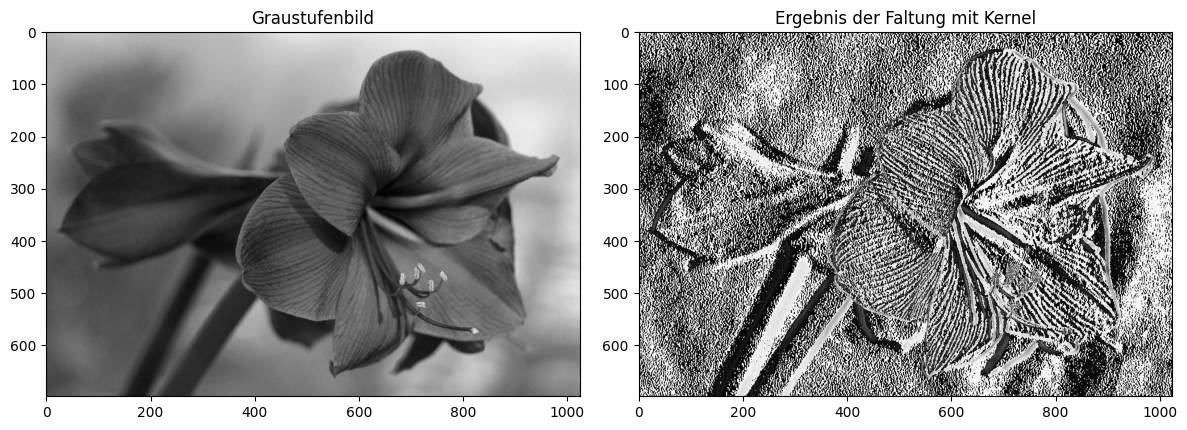

In [ ]:
# Filter definieren
# Hier verwenden wir den klassischen Sobel X Kernel
kernel = np.array([[-1, 0, 1],
                   [-2, 0, 2],
                   [-1, 0, 1]])
# Filter anwenden
ergebnis = convolve(bild_array, kernel)

# Plot
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].imshow(bild_array, cmap='gray')
axs[0].set_title("Graustufenbild")

axs[1].imshow(ergebnis, cmap='gray')
axs[1].set_title(f"Ergebnis der Faltung mit Kernel")

plt.tight_layout()
plt.show()

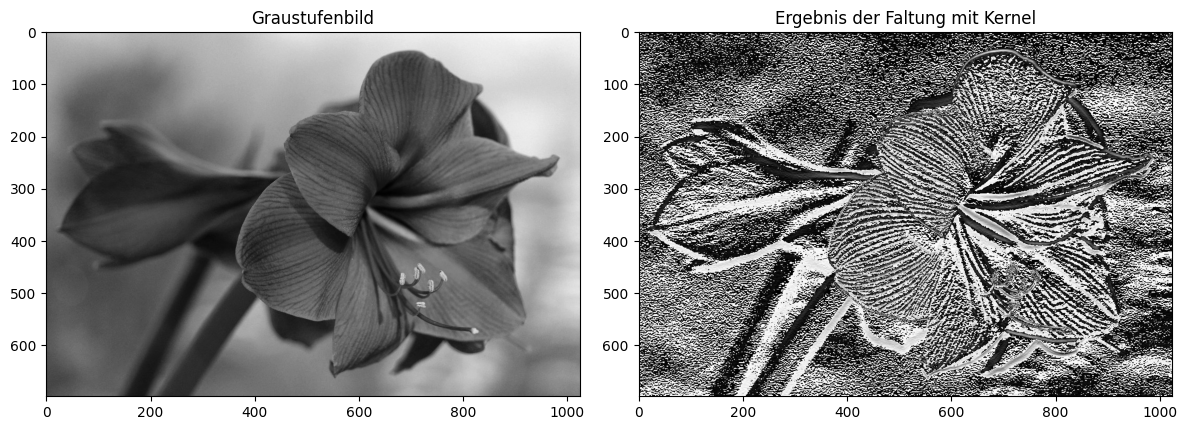

In [ ]:
# Filter definieren
# Hier verwenden wir den klassischen Sobel Y Kernel
kernel = np.array([[-1, -2, -1],
                   [0, 0, 0],
                   [1, 2, 1]])
# Filter anwenden
ergebnis = convolve(bild_array, kernel)

# Plot
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].imshow(bild_array, cmap='gray')
axs[0].set_title("Graustufenbild")

axs[1].imshow(ergebnis, cmap='gray')
axs[1].set_title(f"Ergebnis der Faltung mit Kernel")

plt.tight_layout()
plt.show()

Grundsätzlich ist der Sobel-Operator ein spezieller Kantendetektor, der als diskreter Filter (Kernel) definiert ist und typischerweise auf Bilddaten oder diskrete 2D-Daten angewendet wird.

**Kann man den Sobel-Operator auch auf eine kontinuierliche Funktion anwenden?**

Nicht direkt analytisch, weil der Sobel-Operator auf der diskreten Approximation der Ableitung basiert. Aber was du machen kannst (und was oft gemacht wird):

✅ Du wertest deine Funktion diskret auf einem Gitter aus (so wie du es mit deiner Sinus-Cosinus-Funktion gemacht hast)

✅ Dann kannst du den Sobel-Operator ganz genauso wie auf ein Bild anwenden, weil du ja ein 2D-Array hast

# LaPlace

Der Laplace-Operator ist definiert als die Summe der zweiten Ableitungen einer Funktion:

- Für eine Funktion f(x, y) im 2D-Raum ist:
$$\Delta f = \frac{\partial^2 f}{\partial x^2} + \frac{\partial^2 f}{\partial y^2}$$

- In 3D:
$$\Delta f = \frac{\partial^2 f}{\partial x^2} + \frac{\partial^2 f}{\partial y^2} + \frac{\partial^2 f}{\partial z^2}$$

---
✅ Der Gradient einer Funktion liefert einen Vektor, der die Richtung und Stärke des größten Anstiegs beschreibt. Das ist die erste Ableitung.

✅ Der Laplace-Operator ist die Summe der zweiten partiellen Ableitungen, also ein Maß dafür, wie stark die Funktion in alle Richtungen “gekrümmt” ist.

Man sagt:

$\Delta f = \nabla \cdot \nabla f = \text{div}(\text{grad}(f))$

Das heißt:
- Du bildest zuerst den Gradient (erste Ableitungen → Vektor).
- Dann nimmst du die Divergenz dieses Gradienten (Summe der partiellen Ableitungen der Gradienten-Komponenten).

Fazit:
Der Laplace-Operator ist also nicht der “zweite Gradient”, sondern die Divergenz des Gradienten, was in Summe die Summe der zweiten Ableitungen ergibt.

---- 

In der Bildverarbeitung wird der diskrete Laplace-Operator oft als Filter-Maske angewandt, um Kanten oder schnelle Helligkeitswechsel zu erkennen. 

**Herleitung**
Für ein Bild benötigen wir den LaPlace Operator im 2D-Raum. 

1. Die zweite Ableitung in x-Richtung (diskret) lautet:

    $\frac{\partial^2 f}{\partial x^2} \approx f(x+1, y) - 2f(x, y) + f(x-1, y)$

2. Genauso in y-Richtung:

    $\frac{\partial^2 f}{\partial y^2} \approx f(x, y+1) - 2f(x, y) + f(x, y-1)$

3. Wenn du das zusammenfasst, erhältst du den 2D-Laplace-Kernel:

Typische Filter-Matrix (3x3):

$$\begin{bmatrix}
0 & 1 & 0 \\
1 & -4 & 1 \\
0 & 1 & 0
\end{bmatrix}$$
Das ist klassische 4-neighbourhood Laplace-Kernel, bei dem nur die direkten Nachbarn berücksichtigt werden.

Um resistenter gegen Rotationen zu sein, kann der 8-neighbourhood Laplace-Kernel verwendet werden, der auch Diagonalen berücksichtigt.

$$\begin{bmatrix}
1 & 1 & 1 \\
1 & -8 & 1 \\
1 & 1 & 1
\end{bmatrix}$$

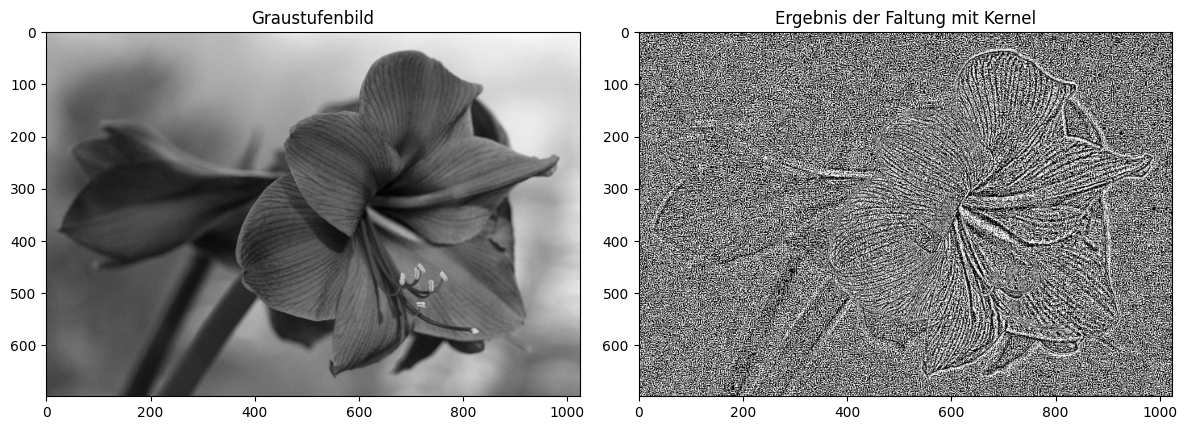

In [49]:
# Filter definieren
# Hier verwenden wir den klassischen 8-neighbourhood Laplace-Kernel
kernel = np.array([[1, 1, 1],
                   [1, -8, 1],
                   [1, 1, 1]])
# Filter anwenden
ergebnis = convolve(bild_array, kernel)

# Plot
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].imshow(bild_array, cmap='gray')
axs[0].set_title("Graustufenbild")

axs[1].imshow(ergebnis, cmap='gray')
axs[1].set_title(f"Ergebnis der Faltung mit Kernel")

plt.tight_layout()
plt.show()

Was du erkennen solltest:

✅ Die Laplace-Berechnung hebt besonders die Stellen hervor, an denen die Krümmung der Funktion wechselt.

✅ Maxima erscheinen negativ, Minima positiv (je nach Konvention). → Die zweite Ableitung von `sin(x)` ist `-sin(x)`

✅ Die wellenartige Struktur bleibt im Laplace-Bild sichtbar, aber zeigt dort die “zweite Ableitung” der Funktion.


Beobachtungen:

✅ Links siehst du die wellenartige Struktur der Sinus-Cosinus-Funktion.

✅ Rechts siehst du, wie der Laplace-Operator die Krümmungsinformationen extrahiert. Maxima, Minima und Sattelstellen werden durch unterschiedliche Farben hervorgehoben.

Warum sind die Minima/Maxima schwach?
1.	Numerische Approximation:
Der scipy.ndimage.laplace Operator verwendet numerische Filter (finite differences), die am Rand stärkere Artefakte erzeugen. Die echten Krümmungen im Inneren erscheinen oft schwächer.
2.	Die Funktion selbst:
Bei einer Funktion wie sin(x) * cos(y) wechseln sich positive und negative Bereiche regelmäßig ab. An vielen Stellen kompensiert sich die Krümmung, weshalb der Laplace-Wert nahe Null bleibt. Die Extremwerte sind nur an bestimmten Punkten deutlich.
3.	Farbschema / Skalierung:
Standardmäßig skaliert plot_surface die Farbtöne automatisch auf die Minimal- und Maximalwerte. Wenn die Werte im Inneren sehr nah an Null liegen und nur am Rand starke Ausschläge vorhanden sind, erscheinen die inneren Unterschiede fast unsichtbar.

→ angepasste Farbskala: 

ax2.plot_surface(X, Y, laplace_Z, cmap='coolwarm', vmin=-0.5, vmax=0.5)

# Gaussian

### 1D Gaussian function

<a>
  <img src="../images/1D_gaussian_function.png" alt="Pinhole camera" width="500" style="background-color: white;padding: 10px;">
</a>

Anhand der 1D Gaussfunktion sollen die Effekte der einzelnen Parameter untersucht werden.

- $ A $ ändert die Höhe

- $ \mu $ verschiebt den Ursprung

- $ \sigma $ verändert die Breite der Glocken/Gausskurve (Standarabweichung)


### 2D Gaussian function

The 2D Gaussian function is given by: 
$$G(x, y) = A \cdot \exp\left( -\left( \frac{(x - x_0)^2}{2\sigma_x^2} + \frac{(y - y_0)^2}{2\sigma_y^2} \right) \right)$$

Where:
- $A$ = Amplitude (peak value)
- $(x_0, y_0)$ = Center of the Gaussian
- $\sigma_x, \sigma_y$ = Standard deviations in x and y direction

# Derivative of Gaussian

# LoG (Laplacian of Gaussian)